# Classification Using Titanic Survival Data:

### Logistic Regression and Decision Tree

In [1]:
# load libraries

import graphviz
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings

warnings.filterwarnings("ignore")

In [2]:
# define plotting characteristics

plt.rcParams["figure.figsize"] = (20,10)

sns.set(font_scale=2)
sns.set_style('whitegrid')

### Data Work

In [3]:
# load data
# print out shape characteristics

dftrain = pd.read_csv('./titanic/train.csv', header=0)
print("Shape of training data: {}".format(dftrain.shape))

dfvalidX = pd.read_csv('./titanic/test.csv', header=0)
dfvalidy = pd.read_csv('./titanic/gender_submission.csv', header=0)
dfvalid = pd.merge(dfvalidX, dfvalidy, how='inner', on='PassengerId')
print("Shape of testing features data: {}".format(dfvalidX.shape))
print("Shape of testing outcomes data: {}".format(dfvalidy.shape))
print("Shape of testing data: {}".format(dfvalid.shape))

Shape of training data: (891, 12)
Shape of testing features data: (418, 11)
Shape of testing outcomes data: (418, 2)
Shape of testing data: (418, 12)


In [4]:
dftrain.head(4)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S


In [5]:
# feature work

# creating 'Title' column from 'Name' column

rare_names = ['Lady.', 'Capt.', 'Col.', 'Don.', 'Dr.', 'Major.', 'Rev.', 'Sir.', 'Jonkheer.', 'Dona.']
map_names = {'Master.': 'Mstr', 'Miss.': 'Wmn', 'Ms.': 'Wmn', 'Mme.': 'Wmn', 
             'Mlle.': 'Wmn', 'Mrs.': 'Wmn', 'Mr.': 'Mn', 'Rare': 'Rare'}

# train dataset
dftrain['Title'] = dftrain['Name'].apply(lambda x: [i for i in x.split(' ') if '.' in i][0])
dftrain["Title"] = dftrain["Title"].replace(rare_names, 'Rare')
dftrain["Title"] = dftrain["Title"].map(map_names)

# test dataset
dfvalid['Title'] = dfvalid['Name'].apply(lambda x: [i for i in x.split(' ') if '.' in i][0])
dfvalid["Title"] = dfvalid["Title"].replace(rare_names, 'Rare')
dfvalid["Title"] = dfvalid["Title"].map(map_names)

# cast 'Pclass' column to object

dftrain['Pclass'] = dftrain['Pclass'].astype('str')
dfvalid['Pclass'] = dfvalid['Pclass'].astype('str')

# create family size column

dftrain['FamilySize'] = dftrain['SibSp'] + dftrain['Parch'] + 1 # plus one is passenger
dfvalid['FamilySize'] = dfvalid['SibSp'] + dfvalid['Parch'] + 1

# drop some columns

dcols = ['Name', 'PassengerId', 'Cabin', 'Ticket', 'SibSp', 'Parch']
dftrain.drop(columns=dcols, inplace=True)
dfvalid.drop(columns=dcols, inplace=True)

# drop rows with missing values

dftrain.dropna(inplace=True)
dfvalid.dropna(inplace=True)

In [6]:
# examine data structure

dftrain.head(2)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize
0,0,3,male,22.0,7.2500,S,Mn,2
1,1,1,female,38.0,71.2833,C,Wmn,2


In [7]:
print(dftrain.dtypes)

Survived        int64
Pclass         object
Sex            object
Age           float64
Fare          float64
Embarked       object
Title          object
FamilySize      int64
dtype: object


In [8]:
# breakdown of binary outcome in both train and test data sets

print(dftrain.Survived.value_counts() / dftrain.shape[0])
print(dfvalid.Survived.value_counts() / dfvalid.shape[0])

0    0.596343
1    0.403657
Name: Survived, dtype: float64
0    0.616314
1    0.383686
Name: Survived, dtype: float64


### Evaluation Function

In [9]:
# define mse metric function
# mse for binary data also called brier score

def mse(act, prd): # brier score
    return round(np.mean(np.power((act - prd), 2)), 4)

### Logistic Regression

In [10]:
# define list of 4 potential logistic regression formulas
# various combinations of the features

formulas = [# all features
            'Survived ~ Age + Fare + FamilySize + C(Pclass) + C(Sex) + C(Embarked) + C(Title)',
            # subset features
            'Survived ~ Age + C(Pclass) + C(Sex) + C(Embarked)']

In [11]:
# number of splits to run for cross-validation

nsplits = 5

# randomly shuffle index numbers

idx = list(range(dftrain.shape[0]))
random.shuffle(idx)

# break shuffled indices into 5 buckets for the 5 splits

n = int(np.ceil(dftrain.shape[0] / nsplits))
indices = [idx[i * n:(i + 1) * n] for i in range((len(idx) + n - 1) // n )]

In [12]:
# cross-validation for model selection
# selection done using residual deviance to residual degrees of freedom ratio
# define best formula at the end

# del lratios

for f in formulas:
    print('Formula: {}'.format(f))
    
    tmp = []
    for i in range(nsplits):
        train_index = sum(indices[:i] + indices[i+1:], [])
        test_index = indices[i]

        trn, tst = dftrain.iloc[train_index], dftrain.iloc[test_index]

        smlr = smf.glm(formula=f, data=trn, family=sm.families.Binomial())
        model_smlr = smlr.fit(method='lbfgs', maxiter=10000, full_output=True)

        deviance_ = model_smlr.deviance
        dfresid_ = model_smlr.df_resid
        tmp.append(deviance_ / dfresid_)
        print('Ratio: {0} / {1}'.format(deviance_, dfresid_))
        
    print('-'*20)
    
    try:
        lratios = np.concatenate((lratios, np.array([tmp])), axis=0)
    except NameError:
        lratios = np.array([tmp])

print('Results:\n{}\n'.format(lratios))
cv_means = np.mean(lratios, axis=1)
print('Cross-validation means:\n{}\n'.format(cv_means))
best_formula_index = np.argmin(cv_means)
best_formula = formulas[best_formula_index]
print('Best formula (by index):\n{}\n'.format(best_formula))

Formula: Survived ~ Age + Fare + FamilySize + C(Pclass) + C(Sex) + C(Embarked) + C(Title)
Ratio: 498.01403954774185 / 556
Ratio: 459.21642322860276 / 556
Ratio: 460.41305023218104 / 556
Ratio: 471.9813717720582 / 556
Ratio: 470.53620672652653 / 560
--------------------
Formula: Survived ~ Age + C(Pclass) + C(Sex) + C(Embarked)
Ratio: 538.2754043369583 / 561
Ratio: 500.7867707063831 / 561
Ratio: 500.0990398995522 / 561
Ratio: 510.60095930487347 / 561
Ratio: 513.5685686770788 / 565
--------------------
Results:
[[0.8957087  0.82592882 0.82808103 0.84888736 0.84024323]
 [0.9594927  0.89266804 0.89144214 0.91016214 0.90897092]]

Cross-validation means:
[0.84776983 0.91254719]

Best formula (by index):
Survived ~ Age + Fare + FamilySize + C(Pclass) + C(Sex) + C(Embarked) + C(Title)



In [13]:
# cross-validation for model stability
# use the best formula defined above
# two metrics: 1) mse (brier) and 2) roc auc
# print out the scores

# del mtrs

for i in range(nsplits):
    print('Iteration: {}'.format(i))
    train_index = sum(indices[:i] + indices[i+1:], [])
    test_index = indices[i]
    
    trn, tst = dftrain.iloc[train_index], dftrain.iloc[test_index]
    
    smlr = smf.glm(formula=best_formula, data=trn, family=sm.families.Binomial())
    model_smlr = smlr.fit(method='lbfgs', maxiter=10000, full_output=True)
    
    ptrn = model_smlr.predict(trn)
    ptst = model_smlr.predict(tst)
    
    ytrn = trn.Survived.values
    ytst = tst.Survived.values
    
    tmp = np.array([[
        mse(ytrn, ptrn), 
        mse(ytst, ptst), 
        round(roc_auc_score(ytrn, ptrn), 4), 
        round(roc_auc_score(ytst, ptst), 4)]
    ])  
        
    try:
        mtrs = np.concatenate((mtrs, tmp), axis=0)
    except NameError:
        mtrs = tmp
        
print('TrainMSE, TestMSE, TrainROC, TestROC')
print(mtrs)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
TrainMSE, TestMSE, TrainROC, TestROC
[[0.1383 0.0976 0.8607 0.9316]
 [0.1243 0.1488 0.8844 0.8329]
 [0.1264 0.1444 0.8802 0.8468]
 [0.1284 0.1331 0.8741 0.8751]
 [0.1272 0.1416 0.8754 0.8621]]


In [14]:
# fit logistic regression model on full training data
# predict the test set for comparison
# calculate same two metrics (mse, roc auc) for both the training and validation data sets

smlr = smf.glm(formula=best_formula, data=dftrain, family=sm.families.Binomial())
model_smlr = smlr.fit(method='lbfgs', maxiter=1000, full_output=True)
    
ptrn = model_smlr.predict(dftrain)
pvld = model_smlr.predict(dfvalid)

ytrn = dftrain.Survived.values
yvld = dfvalid.Survived.values

print('Train MSE: {}'.format(mse(ytrn, ptrn)))
print('Valid MSE: {}'.format(mse(yvld, pvld)))
print('Train ROC: {}'.format(round(roc_auc_score(ytrn, ptrn), 4)))
print('Valid ROC: {}'.format(round(roc_auc_score(yvld, pvld), 4)))

Train MSE: 0.1293
Valid MSE: 0.0911
Train ROC: 0.8745
Valid ROC: 0.9553


In [15]:
# print model summary
# looking at coefficients and other statistics

print(model_smlr.summary())

print('''
Age coef interpretation: The odds for surviving for a person 1 year older 
are exp({0})={1} times the odds of surviving for a person 1 year younger.
Older individuals had a slightly lower chance of survival.
'''.format(-0.0214, round(math.exp(-0.0214), 4)))

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  711
Model:                            GLM   Df Residuals:                      699
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                         lbfgs   Log-Likelihood:                -295.96
Date:                Tue, 25 Feb 2020   Deviance:                       591.92
Time:                        14:06:40   Pearson chi2:                     729.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            6.3523      6.985  

In [16]:
# using the training predicted values to establish the best threshold for defining the classes
# apply that threshold to the validation set
# print out all the metrics

thresholds = np.linspace(0.05, 0.95, 19)
threshold_scores = []

for t in thresholds:
    pclass = [1. if p >= t else 0. for p in ptrn] 
    threshold_scores.append(accuracy_score(ytrn, pclass))

optimal_threshold = round(thresholds[np.argmax(threshold_scores)], 2)
print("Probability Threshold: " + str(optimal_threshold) + "\n")

ptrnclass = [1. if p >= optimal_threshold else 0. for p in ptrn]
pvldclass = [1. if p >= optimal_threshold else 0. for p in pvld]

print("""
------Training Metrics------\n
Confusion Matrix:\n{cntrain}
Accuracy:{acctrain}
ROC AUC Score:{auctrain}\n
------Validation Metrics------\n
Confusion Matrix:\n{cnvalid}
Accuracy:{accvalid}
ROC AUC Score:{aucvalid}""".format(
    cntrain=confusion_matrix(ytrn, ptrnclass),
    acctrain=round(accuracy_score(ytrn, ptrnclass), 3),
    auctrain=round(roc_auc_score(ytrn, ptrn), 3),
    cnvalid=confusion_matrix(yvld, pvldclass),
    accvalid=round(accuracy_score(yvld, pvldclass), 3),
    aucvalid=round(roc_auc_score(yvld, pvld), 3)
))

Probability Threshold: 0.45


------Training Metrics------

Confusion Matrix:
[[366  58]
 [ 64 223]]
Accuracy:0.828
ROC AUC Score:0.875

------Validation Metrics------

Confusion Matrix:
[[173  31]
 [  3 124]]
Accuracy:0.897
ROC AUC Score:0.955


### Decision Tree

In [20]:
# one-hot encode categorical variables
# add interaction terms
#     1) Age * Sex

dftrain = pd.get_dummies(dftrain)
dfvalid = pd.get_dummies(dfvalid)

In [21]:
dftrain.head()

,Survived,Age,Fare,FamilySize,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Mn,Title_Mstr,Title_Rare,Title_Wmn
0,0,22.0,7.2500,2,0,0,1,0,1,0,0,1,1,0,0,0
1,1,38.0,71.2833,2,1,0,0,1,0,1,0,0,0,0,0,1
2,1,26.0,7.9250,1,0,0,1,1,0,0,0,1,0,0,0,1
3,1,35.0,53.1000,2,1,0,0,1,0,0,0,1,0,0,0,1
4,0,35.0,8.0500,1,0,0,1,0,1,0,0,1,1,0,0,0


In [22]:
# split data into X and y

Xtrain = dftrain.drop(columns=['Survived'])
ytrain = dftrain.Survived.values

Xvalid = dfvalid.drop(columns=['Survived'])
yvalid = dfvalid.Survived.values

In [23]:
# fit decision tree model

tree = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=4)
tree.fit(Xtrain, ytrain)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

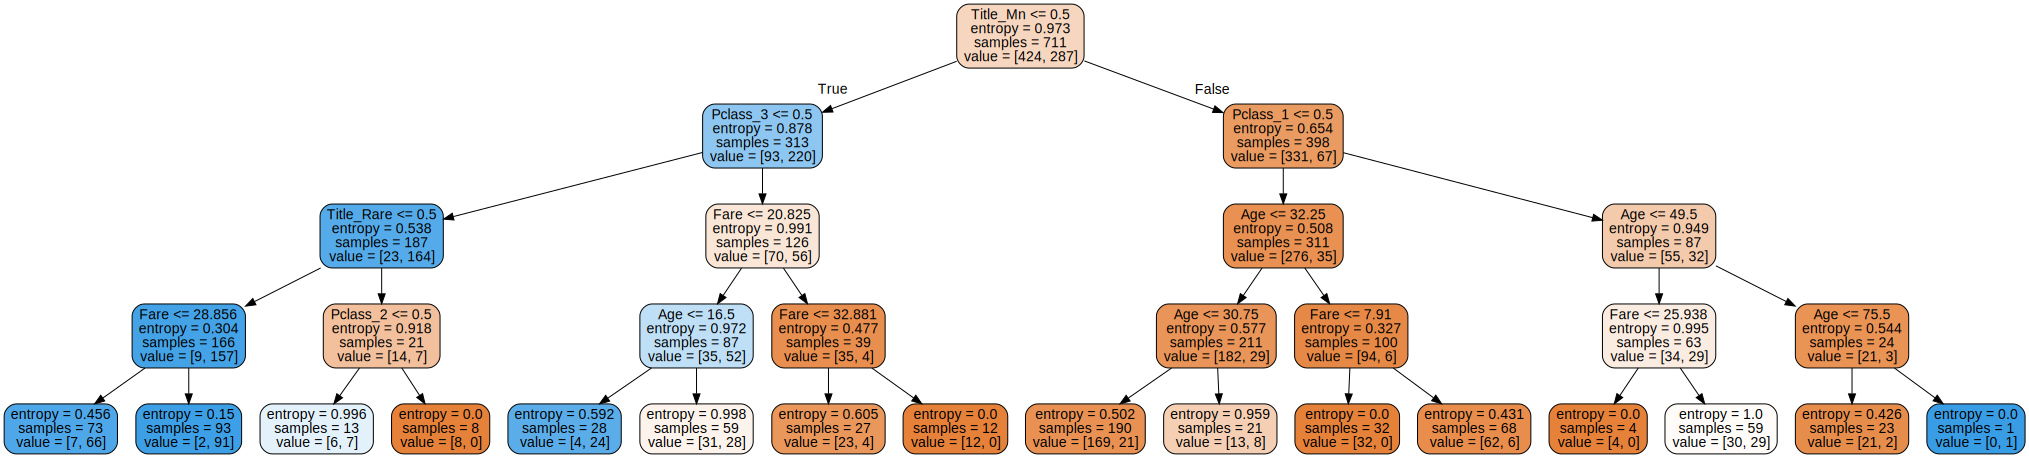

In [24]:
# plot the decision tree

gdata = export_graphviz(tree, feature_names=Xtrain.columns, filled=True, rounded=True)
graph = graphviz.Source(gdata, format="png")
graph

In [25]:
# predict both the training and validation data set

ptrntree = tree.predict_proba(Xtrain)[:, 1]
pvldtree = tree.predict_proba(Xvalid)[:, 1]

In [26]:
# using the training predicted values to establish the best threshold for defining the classes
# apply that threshold to the validation set
# print out all the metrics

thresholds = np.linspace(0.05, 0.95, 19)
threshold_scores = []

for t in thresholds:
    pclass = [1. if p >= t else 0. for p in ptrntree] 
    threshold_scores.append(accuracy_score(ytrn, pclass))

optimal_threshold = round(thresholds[np.argmax(threshold_scores)], 2)
print("Probability Threshold: " + str(optimal_threshold) + "\n")

ptrnclasstree = [1. if p >= optimal_threshold else 0. for p in ptrntree]
pvldclasstree = [1. if p >= optimal_threshold else 0. for p in pvldtree]

print("""
------Training Metrics------\n
Confusion Matrix:\n{cntrain}
Accuracy:{acctrain}
ROC AUC Score:{auctrain}\n
------Validation Metrics------\n
Confusion Matrix:\n{cnvalid}
Accuracy:{accvalid}
ROC AUC Score:{aucvalid}""".format(
    cntrain=confusion_matrix(ytrain, ptrnclasstree),
    acctrain=round(accuracy_score(ytrain, ptrnclasstree), 3),
    auctrain=round(roc_auc_score(ytrain, ptrntree), 3),
    cnvalid=confusion_matrix(yvalid, pvldclasstree),
    accvalid=round(accuracy_score(yvalid, pvldclasstree), 3),
    aucvalid=round(roc_auc_score(yvalid, pvldtree), 3)
))

Probability Threshold: 0.5


------Training Metrics------

Confusion Matrix:
[[405  19]
 [ 98 189]]
Accuracy:0.835
ROC AUC Score:0.905

------Validation Metrics------

Confusion Matrix:
[[189  15]
 [ 42  85]]
Accuracy:0.828
ROC AUC Score:0.901


### ROC Curves

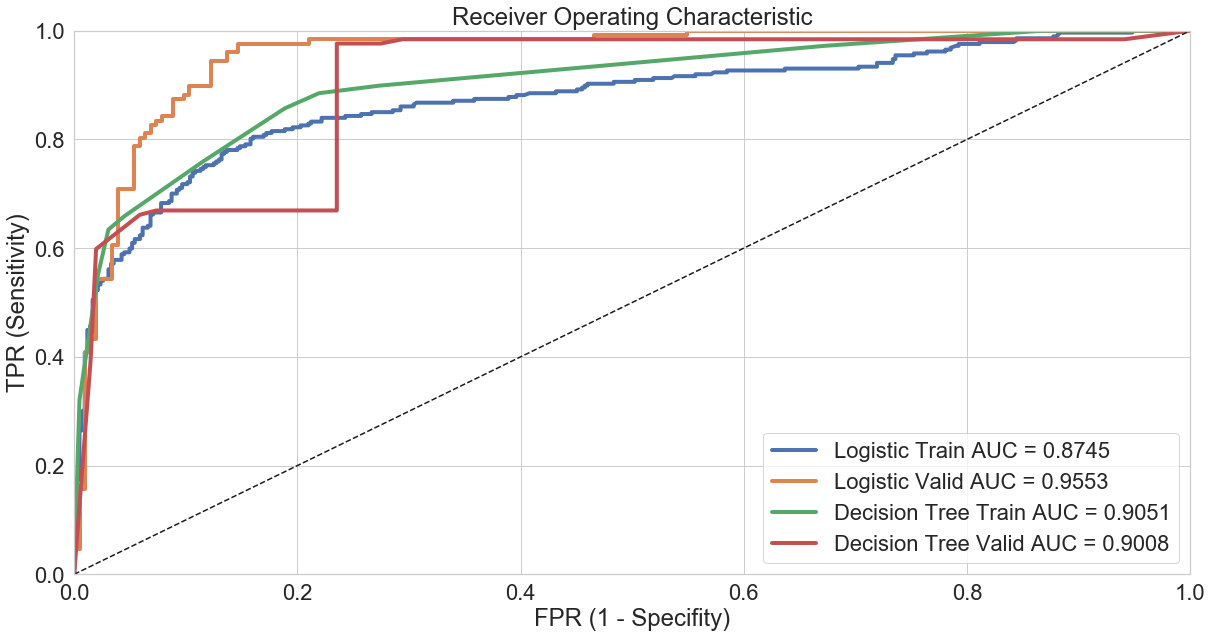

In [27]:
# print roc curve for both logistic regression and cart models for comparison purposes

# logistic
tfpr, ttpr, tthresholds = roc_curve(ytrn, ptrn)
tauc = roc_auc_score(ytrn, ptrn)
vfpr, vtpr, vthresholds = roc_curve(yvld, pvld)
vauc = roc_auc_score(yvld, pvld)

plt.plot(tfpr, ttpr, linewidth=4, label='Logistic Train AUC = {}'.format(round(tauc, 4)))
plt.plot(vfpr, vtpr, linewidth=4, label='Logistic Valid AUC = {}'.format(round(vauc, 4)))

# decision tree
tfprtree, ttprtree, tthresholdstree = roc_curve(ytrain, ptrntree)
tauctree = roc_auc_score(ytrain, ptrntree)
vfprtree, vtprtree, vthresholdstree = roc_curve(yvalid, pvldtree)
vauctree = roc_auc_score(yvalid, pvldtree)

plt.plot(tfprtree, ttprtree, linewidth=4, label='Decision Tree Train AUC = {}'.format(round(tauctree, 4)))
plt.plot(vfprtree, vtprtree, linewidth=4, label='Decision Tree Valid AUC = {}'.format(round(vauctree, 4)))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR (1 - Specifity)')
plt.ylabel('TPR (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

### Calibration Curves

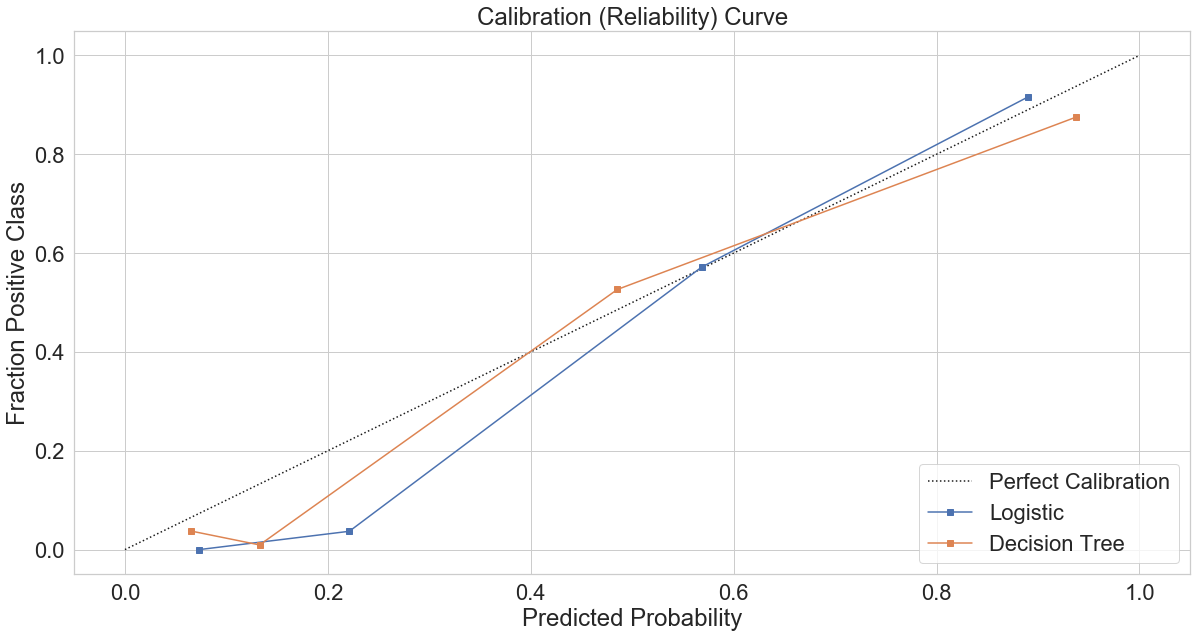

In [28]:
# print calibration curve for both logistic regression and cart models for comparison purposes

# x-axis: predicted probabilities
# y-axis: fraction positive class
# question being answered: where 80% of all 0.80 predicted probabilities of the positive class? 

plt.plot([0, 1], [0, 1], "k:", label='Perfect Calibration')

# logistic regression
frac_pos, mean_pred = calibration_curve(yvld, pvld, n_bins=4, strategy='quantile')
plt.plot(mean_pred, frac_pos, "s-", label='Logistic')

# decision tree
frac_pos_tree, mean_pred_tree = calibration_curve(yvalid, pvldtree, n_bins=4, strategy='quantile')
plt.plot(mean_pred_tree, frac_pos_tree, "s-", label='Decision Tree')

plt.title('Calibration (Reliability) Curve')
plt.xlabel('Predicted Probability')
plt.ylabel('Fraction Positive Class')
plt.legend(loc='lower right')
plt.show()